## Testing evolve tent pitching with solution
$$ \sin\left(ct+\sum_{i=1}^{dim} \sqrt{\frac{1}{dim}}x_i\right)$$

In [1]:
import sys
sys.path.append("..")
from ngsolve import *
SetHeapSize(100*1000*1000)

from ngsolve import *
from ngsolve.comp import *
from ngsolve.TensorProductTools import *
import netgen.meshing as ngm
from netgen.geom2d import unit_square
from netgen.csg import unit_cube
from trefftzngs import *
from prodmesh import * 
from testcases import *
# import netgen.gui
import scipy as sp
import scipy.sparse.linalg
import scipy.linalg
import time
from scipy.io import savemat
from scipy.io import loadmat
from netgen.csg import unit_cube

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpltools import annotation
%matplotlib notebook

## timing

In [2]:
t_start=0
order=3
c=3
t_end=1
initmesh = Mesh(unit_cube.GenerateMesh(maxh=0.4))
bdd = simplesin(initmesh.dim,c)
wavefront = EvolveTentsMakeWavefront(order,initmesh,c,t_start,bdd)
mat = EvolveTents(order,initmesh,c,t_end,wavefront,0,bdd)
l2err = EvolveTentsL2Error(order,initmesh,mat,EvolveTentsMakeWavefront(order,initmesh,c,t_end,bdd))

for t in Timers():
    print(t)

{'name': 'calcdshape', 'time': 3.176151752471924, 'counts': 29420, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'tent eval', 'time': 1.4517877101898193, 'counts': 841, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'tent bnd', 'time': 0.8105525970458984, 'counts': 841, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'tent int bot elvec', 'time': 0.20503902435302734, 'counts': 8405, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'tent int bot calcdshape', 'time': 1.3876802921295166, 'counts': 8405, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'tent int top elmat', 'time': 0.6540751457214355, 'counts': 8405, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'tent int top calcdshape', 'time': 0.9081134796142578, 'counts': 8405, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'tent int', 'time': 3.1823642253875732, 'counts': 841, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'tentsolve', 'time': 0.022621870040893555, 'counts': 841, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'tent', 'time': 5.473642826080322, 'counts': 841, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'pitch tents',

In [3]:
12/841 #30 dofs

0.014268727705112961

## hp-convergence

In [4]:
t_start = 0
t_end = 1

def hpplot(error,xrange,maxh,title=""):
    squashtitle = title.replace(" ", "")
    markers = ["o","X","D","*","P"]
    #fig, (left, right) = plt.subplots(ncols=2, figsize=(10, 5))
    fig = plt.figure()
    #plt.subplot(1, 2, 1)
    ax = fig.gca()
    for i,h in enumerate(maxh):
        plt.semilogy([o-1 for o in xrange] , error[i], '-o', label="h="+str(h))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(title)
    plt.legend()
    plt.ylabel("error")
    plt.xlabel("order")
    #plt.savefig("results/pvtv3_"+label[yaxis]+label[xaxis]+".png")
    #plt.show()
    #fig1 = plt.gcf()
    #plt.show()
    #plt.draw()
    #fig1.savefig('results/convsp_'+squashtitle+"order"+'.png', format='png', dpi=400)
    plt.savefig('../results/convsp_'+squashtitle+"order"+'.eps', format='eps', dpi=1000)
    
    fig = plt.figure()
    #plt.subplot(1, 2, 2)
    ax = fig.gca()
    for i,h in enumerate(list(xrange)): 
        if (squashtitle=="1+1dimensions" and i%2) or squashtitle=="2+1dimensions":
            plt.loglog( maxh, [er[i] for er in error], '-o', label="ord="+str(h-1))
            annotation.slope_marker((0.3,error[2][i]), h+0.5-1,invert=True, ax=ax,size_frac=0.2)
        if(squashtitle=="3+1dimensions"):
            plt.loglog( maxh, [er[i] for er in error], '-o', label="ord="+str(h-1))
            annotation.slope_marker((0.35,error[2][i]+error[2][i]*0.9), h+0.5-1,invert=True, ax=ax,size_frac=0.2)
            #plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    #plt.title('Wavespeed: ' + str(c) + " dim: " + str(initmesh.dim) + "+1")
    plt.gca().invert_xaxis()
    plt.legend()
    plt.title(title)
    plt.ylabel("error")
    plt.xlabel("maxh")
    #plt.savefig("results/pvtv3_"+label[yaxis]+label[xaxis]+".png")
    #plt.show()
    #fig2 = plt.gcf()
    #plt.show()
    #plt.draw()
    #fig2.savefig('results/convsp_'+squashtitle+"maxh"+'.png', format='png', dpi=400)
    plt.savefig('../results/convsp_'+squashtitle+"maxh"+'.eps', format='eps', dpi=1000)
    
def hploop(meshes,maxh,maxorder,c):
    error = [None] * len(meshes)
    for i,initmesh in enumerate(meshes):
        error[i] = []
        bdd = standingwave(initmesh.dim,c)
        for order in range(2,maxorder):
            wavefront = EvolveTentsMakeWavefront(order,initmesh,c,t_start,bdd)
            mat = EvolveTents(order,initmesh,c,t_end,wavefront,0,bdd)
            l2err = EvolveTentsL2Error(order,initmesh,mat,EvolveTentsMakeWavefront(order,initmesh,c,t_end,bdd))
            error[i].append(l2err)
    return error

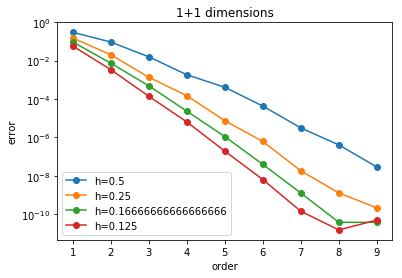

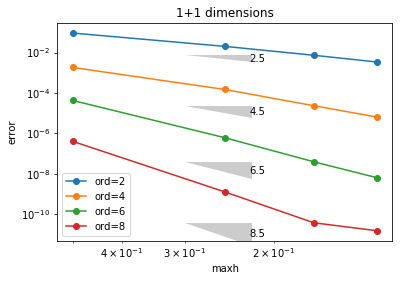

In [5]:
c = 1
maxorder = 11
meshes = [Mesh(SegMesh(h,0,1)) for h in range(2,9,2)]
maxh = [1/h for h in range(2,9,2)]
error = hploop(meshes,maxh,maxorder,c)
hpplot(error,range(2,maxorder),maxh,"1+1 dimensions")

In [6]:
c = 1
maxorder = 6
maxh = [h for h in [0.4,0.2,0.1,0.05,0.025]]
meshes = [Mesh(unit_square.GenerateMesh(maxh=h)) for h in maxh]
error2 = hploop(meshes,maxh,maxorder,c)

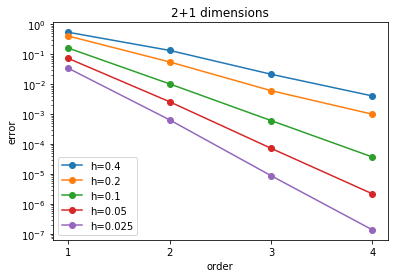

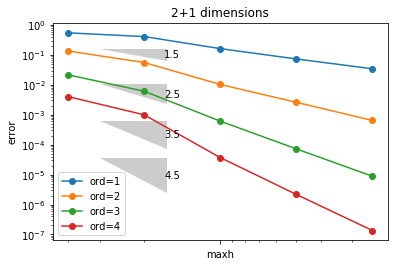

In [7]:
maxorder = 6
maxh = [h for h in [0.4,0.2,0.1,0.05,0.025]]
hpplot(error2,range(2,maxorder),maxh,"2+1 dimensions")

In [8]:
c = 1
t_end = 1
maxorder = 5
maxh = [h for h in [0.3,0.15,0.075,0.063]]
meshes = [Mesh(unit_cube.GenerateMesh(maxh=h)) for h in maxh]
error3 = hploop(meshes,maxh,maxorder,c)

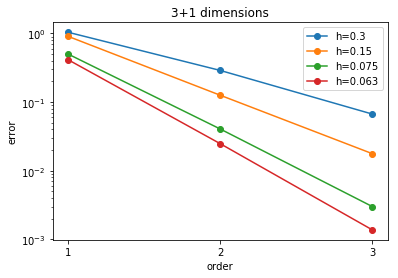

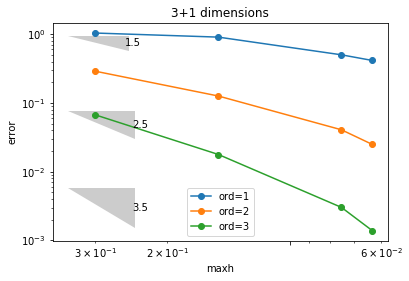

In [14]:
maxorder = 5
maxh = [h for h in [0.3,0.15,0.075,0.063]]
hpplot(error3,range(2,maxorder),maxh,"3+1 dimensions")

## p-convergence 

In [10]:
maxorder=5
c = 3
t_start = 0
t_end = 2
meshes = [Mesh(QadSegMesh(4,0,1)),\
          Mesh(unit_square.GenerateMesh(maxh=0.5)),\
          Mesh(unit_cube.GenerateMesh(maxh = 0.5))]

for initmesh in meshes:
    D=initmesh.dim
    print("dim: " + str(initmesh.dim))
    for order in range(2,maxorder):
        bdd = simplesin(D,c)
        wavefront = EvolveTentsMakeWavefront(order,initmesh,c,t_start,bdd)
        mat = EvolveTents(order,initmesh,c,t_end,wavefront,0,bdd)
        l2err = EvolveTentsL2Error(order,initmesh,mat,EvolveTentsMakeWavefront(order,initmesh,c,t_end,bdd))
        print("order: " + str(order) + " err: " + str(l2err))

dim: 1
order: 2 err: 11.564534635363662
order: 3 err: 3.0947481443587606
order: 4 err: 0.27340866173099215
dim: 2
order: 2 err: 0.24472541085841634
order: 3 err: 0.00978961960722358
order: 4 err: 0.0035169161868528727
dim: 3
order: 2 err: 0.25076380034525864
order: 3 err: 0.012392636370262543
order: 4 err: 0.001498906238993237


## Energy

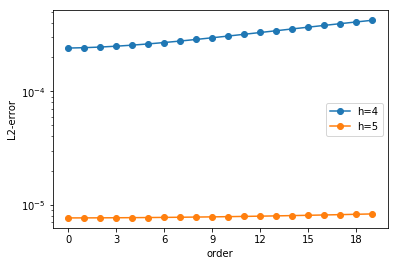

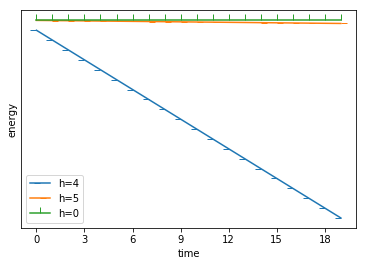

In [11]:
maxorder = 6
minorder=4
t_start = 0
t_step = 50
t_end = 1000
c = 1
initmesh = Mesh(SegMesh(10,0,1)) #Mesh(unit_square.GenerateMesh(maxh=0.09))
bdd = simplesin(initmesh.dim,c)
#for i in range(0,len(initmesh.GetBoundaries())):
#    initmesh.ngmesh.SetBCName(i,"neumann")

error = [None] * (maxorder-minorder+1)
energy = [None] * (maxorder-minorder+1)

for o,order in enumerate(range(minorder,maxorder)):
    t_start = 0
    wavefront = EvolveTentsMakeWavefront(order,initmesh,c,t_start,bdd)
    error[o] = []
    energy[o] = []
    while t_start < t_end:
        wavefront = EvolveTents(order,initmesh,c,t_step,wavefront,t_start,bdd)
        t_start += t_step
        l2err = EvolveTentsL2Error(order,initmesh,wavefront,EvolveTentsMakeWavefront(order,initmesh,c,t_start,bdd))
        egy = EvolveTentsEnergy(order,initmesh,wavefront,c)
        error[o].append(l2err)
        energy[o].append(egy)
        
t_start = 0
error[o+1] = []
energy[o+1] = []
while t_start < t_end:
    t_start += t_step
    energy[o+1].append(EvolveTentsEnergy(order,initmesh,EvolveTentsMakeWavefront(order,initmesh,c,t_start,bdd),c))
foo=list(range(minorder,maxorder))
foo.append(0)

xrange=range(0,int(t_end/t_step))
maxh=range(minorder,maxorder)
fig = plt.figure()
ax = fig.gca()
for i,h in enumerate(maxh):
    plt.semilogy(xrange , error[i], '-o', label="h="+str(h))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#plt.title('Wavespeed: ' + str(c) + " dim: " + str(initmesh.dim) + "+1")
plt.legend()
plt.ylabel("L2-error")
plt.xlabel("order")
#plt.savefig("results/pvtv3_"+label[yaxis]+label[xaxis]+".png")
plt.show()

xrange=range(int(t_end/t_step))
maxh=list(range(minorder,maxorder))
maxh.append(0)
fig = plt.figure()
ax = fig.gca()
for i,h in enumerate(maxh):
    plt.semilogy(xrange , energy[i], marker=i, label="h="+str(h))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#plt.title('Wavespeed: ' + str(c) + " dim: " + str(initmesh.dim) + "+1")
plt.legend()
plt.ylabel("energy")
plt.xlabel("time")
#plt.savefig("results/pvtv3_"+label[yaxis]+label[xaxis]+".png")
plt.show()